In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (6.75, 4.0)

import warnings  # Hide all warnings here
warnings.filterwarnings("ignore")

import mne
mne.utils.set_log_level('error')

import numpy as np
import scipy as sp

from models.preprocessing import utils
from functools import reduce

In [8]:
d = "../../data/reinhartlab/multimodal/cg/Epochs/"
ext = ".stimulus.aggregate.2to100-tfr.h5"
box=utils.select_dataset(d,ext);box

In [9]:
files = [d+f+ext for f in utils.get_selection(box)]
tfrs = [mne.time_frequency.read_tfrs(f)[0] for f in files]

In [10]:
def get_time_slice(tfrs,tmin=None,tmax=0):
    tf = tfrs[0].copy()
    tf.data = np.vstack([np.squeeze(t.data)[:,:,(t.times>=tmin) & (t.times<=tmax)] for t in tfrs])
    return tf

def time_sliced_stats(tfrs,baseline=(-.1,-.001),intervals={'times':(.001,.1),'steps':20},p_threshold=.05):
    

    k=intervals.get('steps',1); T = list(range(k)); c = list(range(k)); p = list(range(k));
    tmin=intervals.get('times',[.001,.1])[0];tmax=intervals.get('times',[.001,.1])[1]
    for i in list(range(k)):
        bsl = get_time_slice(tfrs,baseline[0],baseline[1])
        bsl_mean = np.nanmean(bsl.data,-1)
        
        act_mean = np.nanmean(get_time_slice(tfrs,tmin+(i-1)*tmax,tmax+(i-1)*tmax).data,-1)
        T[i],c[i],p[i],_=mne.stats.permutation_cluster_test([bsl_mean,act_mean])

    m = [[[b in bsl.freqs[x] for b in bsl.freqs] for x,y in zip(a,b) if y<p_threshold] for a,b in zip(c,p)]
    mask = [reduce(lambda x,y: np.logical_or(x,y),[np.ones_like(bsl.freqs)>1,*n]) for n in m]
    return (np.vstack(T).T,np.array(mask).T)

In [178]:
tfrs_visual_negative = [t for t in [tfr["BlockType in {} & FeedbackType == {}".format(["visual/right","visual/left"],"'negative'")] for tfr in tfrs] if len(t)>1]
tfrs_visual_positive = [t for t in [tfr["BlockType in {} & FeedbackType == {}".format(["visual/right","visual/left"],"'positive'")] for tfr in tfrs] if len(t)>1]
tfrs_auditive_negative = [t for t in [tfr["BlockType in {} & FeedbackType == {}".format(["auditive/right","auditive/left"],"'negative'")] for tfr in tfrs] if len(t)>1]
tfrs_auditive_positive = [t for t in [tfr["BlockType in {} & FeedbackType == {}".format(["auditive/right","auditive/left"],"'positive'")] for tfr in tfrs] if len(t)>1]

T_VN,m_VN = time_sliced_stats(tfrs_visual_negative)
T_VP,m_VP = time_sliced_stats(tfrs_visual_positive)
T_AN,m_AN = time_sliced_stats(tfrs_auditive_negative)
T_AP,m_AP = time_sliced_stats(tfrs_auditive_positive)

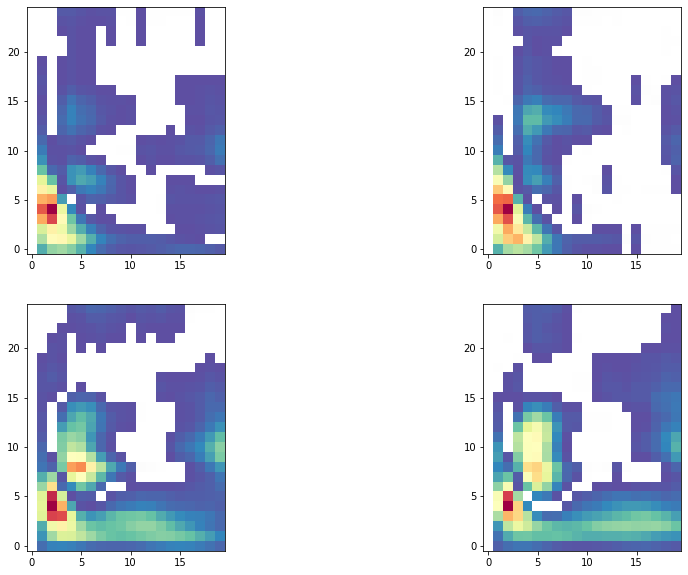

In [186]:
import matplotlib as mplt
cmap = mplt.cm.Spectral_r
cmap.set_bad(alpha=0.)

fig,axs = plt.subplots(2,2, figsize=(15,10))

def plot_masked_tfr(T,m,ax):
    ax.imshow(np.repeat(T,1,-1),origin='lower',cmap='Greys')
    sig_T = np.copy(T)
    sig_T[np.logical_not(m)]=np.nan
    ax.imshow(np.repeat(sig_T,1,-1),origin='lower',cmap='Spectral_r');

plot_masked_tfr(T_AP,m_AP,axs[0][0])
plot_masked_tfr(T_AN,m_AN,axs[0][1])
plot_masked_tfr(T_VP,m_VP,axs[1][0])
plot_masked_tfr(T_VN,m_VN,axs[1][1])

In [ ]:
tfa = mne.grand_average([t.average() for t in tfrs],interpolate_bads=False,drop_bads=False)

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,5));
tfa.plot(axes=axs[0],tmin=-.25,tmax=2.25,baseline=[-.2,0],mode='zscore',colorbar=False,show=False,cmap='Spectral_r');
#tfa.plot(axes=axs[1],tmin=.001,tmax=2.,baseline=[-.2,0],mode='zscore',mask=mask1,mask_alpha=.3,mask_cmap='Greys',cmap='Spectral_r',show=False,colorbar=False);
tfa.plot(axes=axs[1],tmin=.001,tmax=2.,baseline=[-.2,0],fmax=200,mode='zscore',vmin=-10,mask=mask[bsl.freqs<=200,:],mask_alpha=.3,mask_cmap='Greys',cmap='Spectral_r');

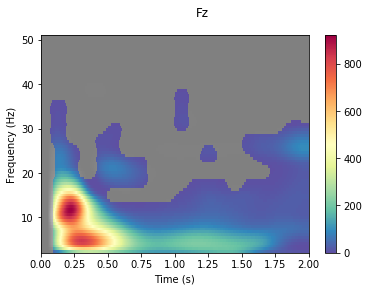

In [204]:
t = np.linspace(.05,1.95,20)
f = bsl.freqs
fqs = np.sort([*f,*(f[:-1]+f[1:])/2])
fqs = np.sort([*fqs,*(fqs[:-1]+fqs[1:])/2])
rbs = sp.interpolate.RectBivariateSpline(t,f,np.array(T))
rbm = sp.interpolate.RectBivariateSpline(t,f,np.array(n)*1.)
tf = tfa.copy().crop(0,2)
tf.data = np.array([rbs(np.linspace(.001,2,2000),fqs).T])
tf.freqs = fqs
fmin = 0;fmax=200;
fm = np.logical_and(fqs>=fmin,fqs<=fmax)
mkwargs = dict(mask=(rbm(np.linspace(.001,2,2000),fqs[fm]).T>.6),mask_alpha=.5,mask_style='mask',mask_cmap='Greys_r')
tf.plot(cmap='Spectral_r',vmin=0,fmin=fmin,fmax=fmax,**mkwargs);#,mask=mask,mask_alpha=.5,mask_cmap='Spectral_r',mask_style='mask');

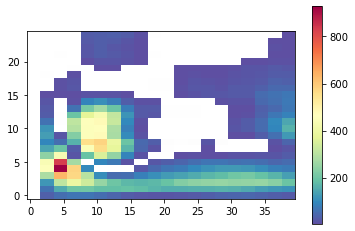

In [185]:
plot_masked_tfr(T_VN,m_VN,plt); plt.colorbar()

In [188]:
tfr = tfrs[0]

In [201]:
mask=np.logical_and(tfr.times>=-.2,tfr.times<=0)

In [204]:
np.mean(tfr.data[:,0,0,mask])

-0.019256288983460636